<span style="color:green; font-family:Papyrus; font-size:2em;">Data Cleaning and Feature Engineering </span>

This Notebook documents the various steps taken to do data cleaning and feature engineering.

<span style="color:red; font-family:Papyrus; font-size:1.5em;">Importing Libraries</span>

In [27]:
# import necessary libraries
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import random

from isbnlib import is_isbn10, is_isbn13, info
import requests

from utils import *

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <span style="color:red; font-family:Papyrus; font-size:1.5em;">Data Cleaning: Raw Data</span>

- Fixing columns names and types and verifying valid values

The first time we ran the dataset via pandas, we ran into a problem. We found out that certain rows content separated by commas, and this confused pandas to interpret them as column or section separator commas. Luckily, we noticed that the content was separated by not just a comma "," but by a comma and space ", ", which made it easy for us to think of solving the problem by replacing the comma with a slash. The new csv file after the update is called books_updated.csv. The following chunk can be uncommented to run it.

In [28]:
### COMMENT THE FOLLOWING CELL IF YOU HAVE ALREADY RUN IT BEFORE AND SAVED THE books_updated.csv ###
# # Specify the filename
filename = 'data/books.csv'
updated_filename = "data/books_updated.csv"

## In some cases in certain fields such us author the authors are separated by ", " 
## to avoid problems when reading the csv directly using pandas and to retain all rows the following steps done

# Open the file and read lines
with open(filename, 'r', encoding='utf-8') as file: # utf-8 encoding to support all languages since there is non-english content
    lines = file.readlines()

# Process the lines to handle unwanted delimiters
cleaned_lines = []
is_firstline = True # used to avoid updating the first line

for line in lines:
    if is_firstline: # if it is the first line i.e. Header do not update it
        is_firstline = False
        cleaned_lines.append(line)
        continue
    cleaned_line = line.replace(', ', '/')

    # Append the cleaned line
    cleaned_lines.append(cleaned_line)

# rejoin all the lines to create a new updated csv
with open(updated_filename, 'w', encoding='utf-8') as output_file:
    for cleaned_line in cleaned_lines:
        output_file.write(cleaned_line + '\n')

<span style="color:blue; font-family:Papyrus; font-size:1.5em;">Reading the Data</span>

In [29]:
# Read the cleaned data into a DataFrame
df = pd.read_csv(updated_filename, delimiter = ",", encoding = 'utf-8', index_col=False) 
# Look at the first 10 rows of the DataFrame
df.head(10)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic
7,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,254,11/1/2005,Gramercy Books
8,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books
9,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown


<span style="color:blue; font-family:Papyrus; font-size:1em;">num_pages column name</span>


- Looking closer at the column names, we notice that in the column '  num_pages' the name starts with space. For practical usage, it is better to remove this unnecessary space.

In [30]:
display(df.columns)
df.rename(columns={'  num_pages': '  num_pages'.replace(' ', '')}, inplace=True)
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

<span style="color:blue; font-family:Papyrus; font-size:1em;">Setting correct types & fixing ISBN</span>

- Examining the column types, it is noticed that some of the columns that are supposed to be numerical types are object types

In [31]:
types_columns=df.dtypes
number_lines, number_columns=df.shape
display(types_columns)
# investigate if there are non-numerical non-date types in supposedly numerical and date columns
# Display the non-numerical and non_date values of the selected columns
columns = ["isbn", "isbn13", "text_reviews_count"]
check_non_numerical_date(df, columns, "numerical")
check_non_numerical_date(df, ["publication_date"], "date")

bookID                 object
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                 object
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count     object
publication_date       object
publisher              object
dtype: object

The non_numerical_values in column isbn :  3        043965548X
12       076790818X
16       076790382X
27       097669400X
40       006076273X
            ...    
11090    030727411X
11101    074347788X
11106    057305133X
11110    843221728X
11115    972233168X
Name: isbn, Length: 985, dtype: object
The non_numerical_values in column isbn13 :  1847    en-US
Name: isbn13, dtype: object
The non_numerical_values in column text_reviews_count :  1847    9/1/2003
Name: text_reviews_count, dtype: object
The non_date_values in column publication_date :  1847      MTV Books
8180     11/31/2000
11098     6/31/1982
Name: publication_date, dtype: object


From the above investigation one can notice the following : 
- We notice that at index 1847 the data is shifted to the left
- Dates at indices 8180 and 11098 were not considered as dates since they are wrong. June and November are 31 days, but in reality they are only 30 days.
- isbn is not numerical since some of the isbn codes end with X 

Before we begin fixing the above two issues, it is important to clarify that 10-digit ISBNs have a X at the end to represent 10. On the other hand, 13-digit ISBNs do not have a X. This is why we chose 13-digit ISBN to be numeric and not 10-digit ISBN.

For the 13-digit ISBN we will try to fix the non-numeric value that exists in it; whereas, for the 10-digit ISBN, we will try to verify if it has invalid ISBN values. THANKFULLY, using the isbnlib library, we verify that all the equivalent 13-digit ISBNs of the non-valid 10-digit ISBNs are valid, which helped us quickly retrieve the valid 10-digit ISBN. We pay attention to the 10-digit ISBN because it is the one with the least non-valid values (5) compared to the 13-digit one (29). The 10-digit ISBN will help us to scrape the genre and country of books with too much complexity.

In [32]:
s = df["isbn"]
non_valid_isbn10 = []
# get non valid isbn
for i in range(len(s)):
    if is_isbn10(s[i]) == False:
        non_valid_isbn10.append((i, df[["isbn", "isbn13"]].loc[i]))
display(non_valid_isbn10)
df["isbn"].iloc[1032] = "0312349483"
df["isbn"].iloc[1847] = "0743470796"
df["isbn"].iloc[3110] = "0842386874"
df["isbn"].iloc[9359] = "1903254388"
df["isbn"].iloc[10330] = "0449015416"
# test
for i in range(len(s)):
    if is_isbn10(s[i]) == False:
        print("invalid ISBN found")

[(1032,
  isbn         0312349486
  isbn13    9780312349486
  Name: 1032, dtype: object),
 (1847,
  isbn      9780743470797
  isbn13            en-US
  Name: 1847, dtype: object),
 (3110,
  isbn          084386874
  isbn13    9780842386876
  Name: 3110, dtype: object),
 (9359,
  isbn         9781903254
  isbn13    9781903254387
  Name: 9359, dtype: object),
 (10330,
  isbn         4490249512
  isbn13    9780449015414
  Name: 10330, dtype: object)]

In [33]:
# fix the dates by replacing 31 with 30 in June and November
# convert the date column to type pd.datetime
df["publication_date"].iloc[8180] = '11/30/2000'
df["publication_date"].iloc[11098] = '6/30/1982'

<span style="color:blue; font-family:Papyrus; font-size:1em;">Unshifting data at index 1847</span>

Now we investigate row 1847. One can notice that there is a / in the bookID which separates the bookID from the book title. This must be the result of the updates we did to the original csv file in the beginning, which led to the shift.

In [34]:
display(df.iloc[1847])
display(df["publisher"][df["publisher"].isna()==True])

bookID                6549/ said the shotgun to the head.
title                                       Saul Williams
authors                                              4.22
average_rating                                743470796.0
isbn                                           0743470796
isbn13                                              en-US
language_code                                         192
num_pages                                            2762
ratings_count                                         214
text_reviews_count                               9/1/2003
publication_date                                MTV Books
publisher                                             NaN
Name: 1847, dtype: object

1847    NaN
Name: publisher, dtype: object

In [35]:
bookid_title = df["bookID"].iloc[1847].split('/')

# content of the remaining columns
remaining_columns = df[['title', 'authors', 'average_rating', 'isbn', 'isbn13',
                                   'language_code', 'num_pages', 'ratings_count', 
                                   'text_reviews_count', 'publication_date']].iloc[1847]

# rearrange cells content for each column
df.iloc[1847, 2:] = remaining_columns
df["bookID"].iloc[1847]= bookid_title[0]
df["title"].iloc[1847]= bookid_title[1]
display(df.iloc[1847])

bookID                                          6549
title                  said the shotgun to the head.
authors                                Saul Williams
average_rating                                  4.22
isbn                                     743470796.0
isbn13                                    0743470796
language_code                                  en-US
num_pages                                        192
ratings_count                                   2762
text_reviews_count                               214
publication_date                            9/1/2003
publisher                                  MTV Books
Name: 1847, dtype: object

In [36]:
# We manually update the isbn at index 1847 as well to remove the .0 from the end
df["isbn"].iloc[1847] = "0743470796"

Now, we check the final results, but for some reasons (has to do with pandas versions) the supposedly numerical columns became objects, which is can be read from the first call to df.info(). We fix again, and can verify that everything is Ok with the last call to df.info()


In [37]:
# Check the types of the columns
display(df.info())
# re-investigate if there is non-numerical content in supposedly numerical columns
columns = ["bookID", "average_rating", "isbn13", "text_reviews_count", "num_pages", "ratings_count", "text_reviews_count"]
check_non_numerical_date(df, columns, "numerical")
# If they do not contain non-numerical content, we will transform them to numerical
columns = ["bookID", "average_rating", "isbn13", "text_reviews_count", "num_pages", "ratings_count", "text_reviews_count"]
df = convert_to_numerical(df, columns)
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   bookID              11127 non-null  object
 1   title               11127 non-null  object
 2   authors             11127 non-null  object
 3   average_rating      11127 non-null  object
 4   isbn                11127 non-null  object
 5   isbn13              11127 non-null  object
 6   language_code       11127 non-null  object
 7   num_pages           11127 non-null  object
 8   ratings_count       11127 non-null  int64 
 9   text_reviews_count  11127 non-null  object
 10  publication_date    11127 non-null  object
 11  publisher           11127 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.0+ MB


None

The non_numerical_values in column bookID :  Series([], Name: bookID, dtype: object)
The non_numerical_values in column average_rating :  Series([], Name: average_rating, dtype: object)
The non_numerical_values in column isbn13 :  Series([], Name: isbn13, dtype: object)
The non_numerical_values in column text_reviews_count :  Series([], Name: text_reviews_count, dtype: object)
The non_numerical_values in column num_pages :  Series([], Name: num_pages, dtype: object)
The non_numerical_values in column ratings_count :  Series([], Name: ratings_count, dtype: int64)
The non_numerical_values in column text_reviews_count :  Series([], Name: text_reviews_count, dtype: object)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors     

None

In [38]:
# Finally we check ISBN
s = df["isbn"]
non_valid_isbn10 = []
for i in range(len(s)):
    if is_isbn10(s[i]) == False:
        non_valid_isbn10.append((i, df[["isbn", "isbn13"]].loc[i]))
display(non_valid_isbn10)

[]

### <span style="color:blue; font-family:Papyrus; font-size:1em;">Getting Genre & Country</span>

At this step, three new features are added: 

- publisher_country : this is the country of the publisher. It is extracted using the isbn
- coordinates : this is the coordinates of the country. It is important in the data analysis and visualization. countries.csv is used to get the coordinates
- genre_category : this represents the genre of the book. It was extracted using google books API. **Note that the process to get the genre takes around 1 hour and half.**

In [39]:
# isbnlib for Country
def new_col(row):
    ctr_lang = info(str(row['isbn'])) # get language from isbn
    if ctr_lang == "English language":
        return random.choice(["United Kingdom", "United States"]) # if english return randomly either "United Kingdom" or "United States"
    elif ctr_lang == "French language":
        return "France"
    elif ctr_lang == "German language":
        return "Germany"
    elif ctr_lang == "former U.S.S.R":
        return "Russia"
    elif ctr_lang == "former Yugoslavia":
        return "Croatia"
    elif ctr_lang == "Hong Kong, China":
        return "China"
    else:
        return ctr_lang
    
df["publisher_country"] = df.apply(new_col, axis=1)

countries = pd.read_csv("data/countries.csv").rename(columns={"name":"publisher_country"})
df = pd.merge(df, countries, on = "publisher_country")
df["coordinates"] = df[["latitude","longitude"]].apply(tuple, axis=1)

In [40]:
df.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publisher_country,country,latitude,longitude,coordinates
1122,3787,Party Shoes (Shoes #5),Noel Streatfeild,3.64,0192752537,9780192752536,en-US,243,430,33,9/1/2002,Oxford University Press USA,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)"
6687,25069,Bright Lights Big City,Jay McInerney/Sylvie Durastanti,3.77,2879290937,9782879290935,fre,192,68,5,10/14/1997,Editions de l'Olivier,France,FR,46.227638,2.213749,"(46.227638, 2.213749)"
3893,13913,How To Have A Beautiful Mind,Edward de Bono,3.62,0091894603,9780091894603,en-US,232,1595,135,6/3/2004,Vermilion,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)"
8700,33512,One Thousand White Women: The Journals of May ...,Jim Fergus,3.88,0312199430,9780312199432,eng,434,100949,7615,2/15/1999,St. Martin's Griffin,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
9578,38128,Law and Literature,Richard A. Posner,3.61,0674514718,9780674514713,eng,432,95,6,3/15/1998,Harvard University Press,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"


In [41]:
# Google Book for Genre
def get_genre(row):
    isbn = str(row["isbn"])
    response = requests.get('https://www.googleapis.com/books/v1/volumes?q=isbn:'+isbn)
    resp_json_payload = response.json()
    try:
        res = resp_json_payload['items'][0]['volumeInfo']['categories']
        return res[0]
    except:
        return random.choice(["Fiction", "Juvenile Fiction", "Biography & Autobiography"])
    
# df["genre_category"] = df.apply(get_genre, axis=1)
df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publisher_country,country,latitude,longitude,coordinates
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)"
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)"
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)"
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"


In [42]:
df.sample(3)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publisher_country,country,latitude,longitude,coordinates
6643,24953,Danny The Champion Of The World,Roald Dahl/Quentin Blake,4.09,022406469X,9780224064699,eng,256,107,9,11/7/2002,Jonathan Cape,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
7116,27277,Glass House,Philip Johnson/Toshio Nakamura,4.00,1580931863,9781580931861,eng,256,14,2,5/10/2007,The Monacelli Press,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)"
7216,27669,Bury the Chains,Adam Hochschild,4.28,0333904915,9780333904916,eng,467,13,1,3/18/2005,MacMillan,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"


## <span style="color:red; font-family:Papyrus; font-size:1.5em;">Data Cleaning: Scraped Data</span>

This data cleaning is done on the data set after doing webscraping. We did two webscraping, one through Goodreads (found in scraper folder), and the second through Google Books, as seen above. We also used an ISBN Python library to extract the country feature. 

Through Goodreads extra features were extracted which are: 
- first_published : this is the date a book was first published (this will help distinguish two different books with the same name)
- book_format : this is the format of the book (some books are present in different formats (paperback, Audio CD, hardcover))
- new_publisher: this is because it was noticed that in the original data some books had wrong publishers
- edition_avgRating: this is the actual average rating of each edition
- added_toShelves: this is the number of users that added a book to shelves

Through Google Books the feature that was extracted is:
- genre_category : this represents the genre of the book

Through Python Library isbnlib the feature that was extracted is:
- publisher_country :  this is the country of the publisher

*For more details about the process of GoodReads scraping, please refer to scraper/scraper.py*

### <span style="color:blue; font-family:Papyrus; font-size:1.5em;">Reading the Data</span>

In [43]:
# read the scraped data
goodread_scraped = pd.read_csv("scraper/booksRating_extraFeats.csv")
goodread_scraped = goodread_scraped[["first_published", "book_format", "new_publisher", "edition_avgRating", "added_toShelves"]]
df_scraped = pd.concat([df, goodread_scraped], axis=1).reindex(df.index)
df_scraped.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,publisher_country,country,latitude,longitude,coordinates,first_published,book_format,new_publisher,edition_avgRating,added_toShelves
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","July 16, 2005",Paperback,Scholastic Inc,4.57,4405980.0
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","June 21, 2003",Paperback,Scholastic Inc.,4.50,4518536.0
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","July 2, 1998",Hardcover,NaN,4.05,7469.0
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,...,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","July 8, 1999",Mass Market Paperback,Scholastic Inc.,4.57,5223956.0
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","October 1, 2003",Paperback,Scholastic,4.72,172736.0


In [44]:
df_scraped.tail()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,publisher_country,country,latitude,longitude,coordinates,first_published,book_format,new_publisher,edition_avgRating,added_toShelves
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,...,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","December 1, 2004",Paperback,Da Capo Press,4.06,552.0
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","June 27, 1987",Paperback,Penguin Books,4.04,4269.0
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,...,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","January 1, 1990",Paperback,Penguin Publishing Group,3.98,4686.0
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","January 1, 2007",Hardcover,Ecco,3.75,2948.0
11126,45641,Las aventuras de Tom Sawyer,Mark Twain,3.91,8497646983,9788497646987,spa,272,113,12,...,Spain,ES,40.463667,-3.749220,"(40.463667, -3.74922)","June 1, 1876",Paperback,NaN,3.72,228.0


In [45]:
df_scraped.info()
# df_scraped.isnull().any()
df_scraped.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  int64  
 6   language_code       11127 non-null  object 
 7   num_pages           11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
 12  publisher_country   11127 non-null  object 
 13  country             11127 non-null  object 
 14  latitude            11127 non-null  float64
 15  longitude           11127 non-null  float64
 16  coor

bookID                   0
title                    0
authors                  0
average_rating           0
isbn                     0
isbn13                   0
language_code            0
num_pages                0
ratings_count            0
text_reviews_count       0
publication_date         0
publisher                0
publisher_country        0
country                  0
latitude                 0
longitude                0
coordinates              0
first_published          2
book_format              1
new_publisher         2767
edition_avgRating        3
added_toShelves          3
dtype: int64

### <span style="color:blue; font-family:Papyrus; font-size:1em;">Imputation</span>

In the new dataset, there are 2 NaN in the first_published, 1 in the book_format, 3 in both the edition_avgRating and added_toShelves. These were values that the scraper failed to get. Since they are very few, they will be filled manually. 

In [46]:
df_scraped[df_scraped[["first_published", "book_format", "edition_avgRating", "added_toShelves"]].isna().any(axis=1)]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,publisher_country,country,latitude,longitude,coordinates,first_published,book_format,new_publisher,edition_avgRating,added_toShelves
2255,8077,Animales No Se Visten Los (Animals Should Def...,Judi Barrett/Ron Barrett,4.11,1595191356,9781595191359,eng,32,0,0,...,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","January 1, 1970",Paperback,Atheneum Books for Young Readers,NaN,NaN
6396,24062,The Deep (Dive Trilogy),Gordon Korman,3.78,0613674839,9780613674836,eng,148,0,0,...,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)",NaN,NaN,NaN,NaN,NaN
8476,32552,Essential Tales and Poems,Edgar Allan Poe/Benjamin F. Fisher,4.36,1593080646,9781593080648,en-US,688,66382,109,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",NaN,Paperback,Barnes & Noble Classics,4.36,92622.0
8520,32703,The Diary of Ellen Rimbauer: My Life at Rose Red,Joyce Reardon/Steven Rimbauer/Ridley Pearson,3.67,0786890436,9780786890439,eng,277,7852,352,...,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","January 1, 2001",Mass Market Paperback,Hyperion,NaN,NaN


In [47]:
df_scraped.loc[2255, ["edition_avgRating", "added_toShelves"]] = [4.11, 5402]
# As the information on the goodreads page are not exactly the same as the ones in line 6385, the information is refilled manually based on the GoddReads page (the title, num_pages and average rating were the same in the database and the link to goodread).
df_scraped.loc[6396, ["ratings_count", "text_reviews_count", "first_published","book_format","new_publisher","edition_avgRating","added_toShelves"]] = [1659,66,"July 1, 2003","Paperback","Scholastic",3.78,3004]
df_scraped.loc[8476, ["first_published"]] = ["January 1, 1843"]
df_scraped.loc[8520, ["edition_avgRating", "added_toShelves"]] = [3.7, 15942]

For the new_publisher, the scraper failed to retrieve a lot of values, this is because of how the publisher is saved in the html. Due to the constraint of time, and since there is already a publisher column in the original dataset, we will update the old publisher only when both values exist and both are different.

In [48]:
for index, row in df_scraped.iterrows():
    # Check if the new publisher is different from the old publisher
    if pd.notna(row['new_publisher']) and row['new_publisher'] != row['publisher']:
        # Update the publisher with the new publisher value
        df_scraped.at[index, 'publisher'] = row['new_publisher']
    else:
        # Use the old publisher if the new publisher is NaN or the same as the old publisher
        df_scraped.at[index, 'publisher'] = row['publisher']

display(df_scraped[["publisher", "new_publisher"]].sample(5))
# drop new_publisher column
df_scraped.drop(columns="new_publisher", inplace=True)
display(df_scraped)

,publisher,new_publisher
6582,Henry Holt and Company,Henry Holt and Company
243,For Dummies,For Dummies
1619,Omohundro Institute and University of North Ca...,Omohundro Institute and University of North Ca...
5487,Little Brown & Company,NaN
2754,Napoleon and Co,Napoleon and Co


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,publisher,publisher_country,country,latitude,longitude,coordinates,first_published,book_format,edition_avgRating,added_toShelves
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,Scholastic Inc,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","July 16, 2005",Paperback,4.57,4405980.0
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,...,Scholastic Inc.,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","June 21, 2003",Paperback,4.50,4518536.0
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,...,Scholastic,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","July 2, 1998",Hardcover,4.05,7469.0
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,...,Scholastic Inc.,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","July 8, 1999",Mass Market Paperback,4.57,5223956.0
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,...,Scholastic,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","October 1, 2003",Paperback,4.72,172736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,...,Da Capo Press,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","December 1, 2004",Paperback,4.06,552.0
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,...,Penguin Books,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","June 27, 1987",Paperback,4.04,4269.0
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,...,Penguin Publishing Group,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","January 1, 1990",Paperback,3.98,4686.0
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,...,Ecco,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","January 1, 2007",Hardcover,3.75,2948.0


In [49]:
display(df_scraped)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,publisher,publisher_country,country,latitude,longitude,coordinates,first_published,book_format,edition_avgRating,added_toShelves
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,Scholastic Inc,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","July 16, 2005",Paperback,4.57,4405980.0
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,...,Scholastic Inc.,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","June 21, 2003",Paperback,4.50,4518536.0
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,...,Scholastic,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","July 2, 1998",Hardcover,4.05,7469.0
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,...,Scholastic Inc.,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","July 8, 1999",Mass Market Paperback,4.57,5223956.0
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,...,Scholastic,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","October 1, 2003",Paperback,4.72,172736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,...,Da Capo Press,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","December 1, 2004",Paperback,4.06,552.0
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,...,Penguin Books,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","June 27, 1987",Paperback,4.04,4269.0
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,...,Penguin Publishing Group,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","January 1, 1990",Paperback,3.98,4686.0
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,...,Ecco,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)","January 1, 2007",Hardcover,3.75,2948.0


By insepcting the data more, we notice that sometimes the dates in the first_published weren't extracted correctly, for example instead of January we find "ary".

In [50]:
display(df_scraped.first_published.sample(5))
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 20)
df_scraped[['title','first_published']][df_scraped['first_published'].str.contains(r'\bary\b', case=False) & ~df_scraped['first_published'].str.contains(r'january|february', case=False)]
# We will replace the "ary" in those line by "february" 
# Filter rows containing "ary" but not "january" or "february"
filtered_rows = df_scraped['first_published'].str.contains(r'ary', case=False) & ~df_scraped['first_published'].str.contains(r'january|february', case=False)
# Replace the filtered results with "february" 
df_scraped.loc[filtered_rows, 'first_published'] = df_scraped.loc[filtered_rows, 'first_published'].str.replace(r'ary', 'february', case=False) # we don't need =
df_scraped[['title','first_published']][df_scraped['first_published'].str.contains('published', case=False)]
# Let's delete the word "published" from the first_published column
df_scraped['first_published'] = df_scraped['first_published'].str.replace('published ', '')

3484     January 1, 1974
11068    January 1, 2006
9565        June 1, 1975
5576     January 1, 1951
6744     January 1, 2004
Name: first_published, dtype: object

### <span style="color:blue; font-family:Papyrus; font-size:1em;">Text Columns to Lower Case</span>

When dealing with text data it always safer to have them all in the same case either lower or upper 

In [51]:
# get the text columns
text_columns = df_scraped.select_dtypes(include=['object'], )
text_columns = text_columns.loc[:, text_columns.columns != 'coordinates'].columns
# Convert to lowercase
df_scraped = to_lower(df_scraped, text_columns)
df_scraped.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,publisher,publisher_country,country,latitude,longitude,coordinates,first_published,book_format,edition_avgRating,added_toShelves
689,2219,baby signing for dummies,jennifer watson,3.64,0471773867,9780471773863,eng,257,37,9,...,for dummies,united kingdom,gb,55.378051,-3.435973,"(55.378051, -3.435973)","january 1, 2006",paperback,3.68,117.0
7881,30284,nachtschwärmer (meredith gentry #2),laurell k. hamilton,4.06,3442358957,9783442358953,ger,586,13,0,...,blanvalet taschenbuch verlag,germany,de,51.165691,10.451526,"(51.165691, 10.451526)","march 1, 2002",paperback,3.58,29.0
3020,11138,mere christianity,c.s. lewis,4.32,0684823780,9780684823782,eng,191,240060,5828,...,touchstone books,united kingdom,gb,55.378051,-3.435973,"(55.378051, -3.435973)","january 1, 1942",paperback,4.30,425531.0
5193,18803,the way by swann’s (in search of lost time #1),marcel proust/lydia davis/christopher prendergast,4.14,0141180315,9780141180311,eng,489,318,52,...,penguin classics,united states,us,37.090240,-95.712891,"(37.09024, -95.712891)","november 14, 1913",paperback,4.17,3011.0
1276,4411,eden in the east: the drowned continent of southeast asia,stephen oppenheimer,3.98,0753806797,9780753806791,eng,575,99,15,...,orion publishing,united states,us,37.090240,-95.712891,"(37.09024, -95.712891)","january 1, 1998",paperback,3.99,665.0


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create num_contributors</span>

We have decided to take only the name of the first author, since usually first authors are the main authors. num_contributors column will be added to indicate the total number of authors/contributors to the book.

In [52]:
# take the first author in the authors column
df_scraped["first_author"] = df_scraped["authors"].apply(lambda x: x.split("/")[0].strip())
df_scraped["first_author"].sample(5)
df_scraped["num_contributors"] = df_scraped["authors"].apply(lambda x: len(x.split("/")))
df_scraped[["authors","num_contributors"]].sample(5)

,authors,num_contributors
2641,erica jong,1
2426,antoine de saint-exupéry,1
5947,neil gaiman,1
1937,emma holly,1
1918,ian mcewan,1


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Clean Text Columns</span>

Remove punctuation, and extra white spaces from all text columns. We'd also better clean the text in publisher column, to avoid having same publishers represented differently. 
Example: indexes 5993, 5365 and 9753, W.W. Norton & Company, W. W. Norton and Company and W. W. Norton  Company represent the same publisher

In [53]:
general_replacements = [
    (r'[^\w\s]', ''), # remove punctuation
    (r'\s\s+', " "), # remove double spaces and more
]
columns_ = ["title", "first_author"]
df_scraped = sub_text(df_scraped, columns_, general_replacements)
# strip to remove spaces from beginning and end
df_scraped["title"] = df_scraped["title"].str.strip()
df_scraped["first_author"] = df_scraped["first_author"].str.strip()
df_scraped[["title", "first_author"]].sample(5)

# specific replacements on publishers
specific_replacements = [
    (r'\binc.?\b', ""), #remove inc
    (r'\bllc.?\b', ""), #remove llc
    (r'\bltd.?\b', ""), #remove ltd
    (r"w. w.", "ww"), #convert w. w. to ww
    (r"&", " and "), #substiute & by and
    (r'\([^)]*\)', ''), #remove everything within parentheses
    (r"\bpaperbacks?\b", ""), #remove paperback or paperbacks
    (r'\bbooks?\b', ""),  #remove book and books
    (r'\bclassics?\b', ""), #remove classic and classics
    (r'\bpublishers?\b', ""), #remove publisher or publishers
    (r'\bpress\b', ""), #remove press
    (r'\bpublishing\b', ""), #remove publishing
    (r'\bpublications?\b', ""), #remove publication or publications
    (r'\bgroups?\b', "") #remove group or groups
]
df_scraped = sub_text(df_scraped, ["publisher"], specific_replacements)
#apply the general replacements on the publisher column 
df_scraped = sub_text(df_scraped, ["publisher"], general_replacements)
# strip to remove spaces from beginning and end
df_scraped["publisher"] = df_scraped["publisher"].str.strip()
df_scraped.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,country,latitude,longitude,coordinates,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors
10439,42434,sandworms of dune dune chronicles 8,brian herbert/kevin j. anderson,3.64,076531293x,9780765312938,en-us,494,8486,273,...,gb,55.378051,-3.435973,"(55.378051, -3.435973)","august 7, 2007",hardcover,3.63,32623.0,brian herbert,2
6744,25296,the dark mirror the bridei chronicles 1,juliet marillier,3.97,0765348756,9780765348753,en-us,561,7525,376,...,gb,55.378051,-3.435973,"(55.378051, -3.435973)","january 1, 2004",mass market paperback,3.98,17669.0,juliet marillier,1
7292,28054,river of shadows eadweard muybridge and the technological wild west,rebecca solnit,4.15,0142004103,9780142004104,eng,320,1148,133,...,gb,55.378051,-3.435973,"(55.378051, -3.435973)","january 1, 2003",paperback,4.17,5918.0,rebecca solnit,1
8074,31034,pink box inside japans sex clubs,joan sinclair/james farrer,4.11,0810992590,9780810992597,eng,192,260,32,...,us,37.090240,-95.712891,"(37.09024, -95.712891)","october 1, 2006",paperback,4.10,1070.0,joan sinclair,2
4043,14367,island of the blue dolphins,scott o'dell/tantoo cardinal,3.83,0307243168,9780307243164,en-us,4,205,49,...,us,37.090240,-95.712891,"(37.09024, -95.712891)","september 9, 1960",audio cd,3.82,444.0,scott odell,2


### <span style="color:blue; font-family:Papyrus; font-size:1em;">edition_avgRating vs. average_rating</span>

We have a look at the edition_avgRating to see if it differs a lot from the original average_rating

In [54]:
display(df_scraped['edition_avgRating'].isna().any())
df_rating = df_scraped.copy()
df_rating['diff_rating'] = df_rating['average_rating'] - df_rating['edition_avgRating']
filtered_df = df_rating[df_rating['diff_rating'] != 0]
# Check cases when the average_rating is different from edition_avgRating
display(filtered_df[['title', 'average_rating', 'edition_avgRating']].sample(10))
display('The average mean of difference between average rating and edition rating is ', round(df_rating['diff_rating'].mean(), 2) )

False

,title,average_rating,edition_avgRating
2691,angels,3.72,3.96
620,the frogs,3.80,3.25
1298,the far side of evil,3.98,3.62
10177,les fils des ténèbres,3.71,3.55
4088,peace is every step the path of mindfulness in everyday life,4.33,4.31
2912,the sword of straw the sangreal trilogy 2,3.81,3.89
3646,the jester,3.80,3.81
4811,the very best of the feynman lectures,4.18,4.15
4141,the sword of angels the bronze knight 3,3.90,3.92
234,the kingdom of god is within you,4.13,4.16


'The average mean of difference between average rating and edition rating is '

0.03

Distribution of average rating vs. edition rating

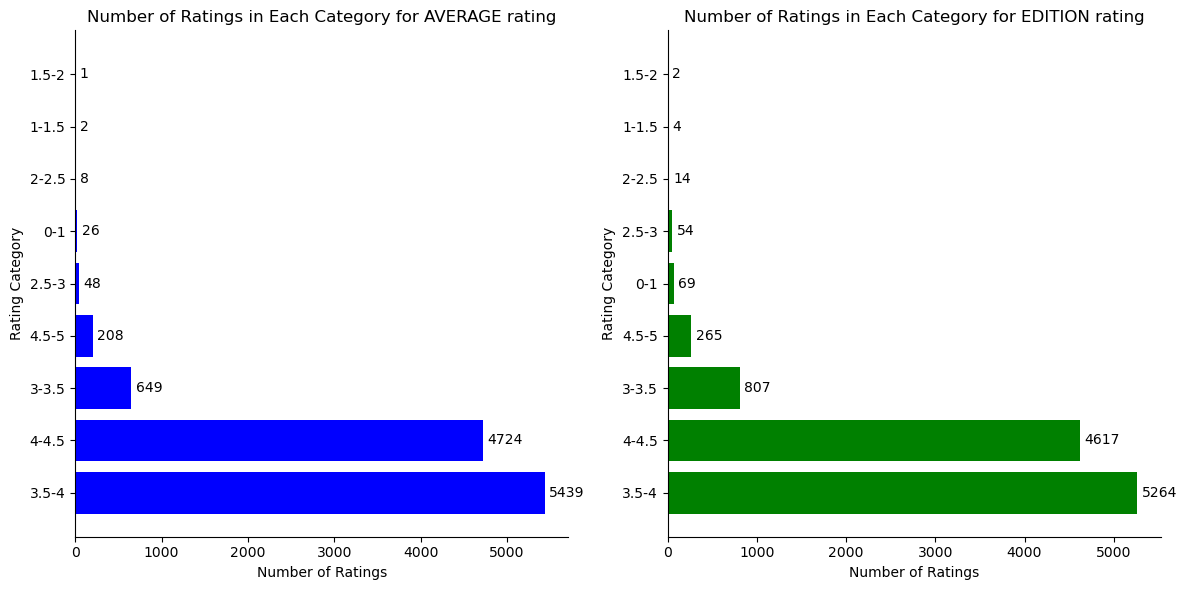

In [55]:
#We need to know if the distribution is the same for average rating or edition rating :
# Define bins and labels for average rating and edition rating
bins = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = ['0-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4', '4-4.5', '4.5-5']

# Create a new column with the bin labels for average rating and edition rating
df_rating['average_rating_category'] = pd.cut(df_rating['average_rating'], bins=bins, labels=labels, right=False)
df_rating['edition_rating_category'] = pd.cut(df_rating['edition_avgRating'], bins=bins, labels=labels, right=False)

# Count the number of ratings in each category for both
rating_counts_per_category_average = df_rating['average_rating_category'].value_counts()
rating_counts_per_category_edition = df_rating['edition_rating_category'].value_counts()

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first graph based on df_scraped['average_rating']
axs[0].barh(rating_counts_per_category_average.index, rating_counts_per_category_average.values, color='blue')
axs[0].set_title('Number of Ratings in Each Category for AVERAGE rating')
axs[0].set_xlabel('Number of Ratings')
axs[0].set_ylabel('Rating Category')

# Add values on top of each bar for the first graph
for index, value in enumerate(rating_counts_per_category_average):
    axs[0].text(value+50, index, str(value), ha='left', va='center')

# Plot the second graph based on df_scraped['edition_avgRating']
axs[1].barh(rating_counts_per_category_edition.index, rating_counts_per_category_edition.values, color='green')
axs[1].set_title('Number of Ratings in Each Category for EDITION rating')
axs[1].set_xlabel('Number of Ratings')
axs[1].set_ylabel('Rating Category')

# Add values on top of each bar for the second graph
for index, value in enumerate(rating_counts_per_category_edition):
    axs[1].text(value+50, index, str(value), ha='left', va='center')

# Remove upper and right borders for both subplots
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Looking at the mean calculated for the difference of between the two ratings, we see that it is very small = 0.03. So for the vast majority of books, there are very few differences between the 2 ratings. But, in order to add more relevance to the new data scraped (like book format) and more coherence to already existing data (publication_date and number_of_pages which are specific to the edition), we will now only refer to the edition_avgRating column for our target.

### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create size_of_publisher</span>

The exact number of times a publisher name is in the database is not as relevant as the number of time an author or a title is in it.
So instead of the count, create a column that categorize the publisher :
- Small publisher (1) = 10 or less times in the database
- Medium publisher (2) = between 10 annd 30 times
- big publisher (3) = more that 30 times

In [56]:
# Adding the new columns that allows to see if a publisher is often cited
df_scraped['publisher_count'] = df_scraped.groupby('publisher')['publisher'].transform('count')
publisher_count_ranges = [0, 11, 31, float('inf')] # [0, 10] --> 1 - [11, 30] --> 2, [30, +inf] --> 3
df_scraped['size_of_publisher'] = pd.cut(df_scraped['publisher_count'], bins=publisher_count_ranges, labels=[1, 2, 3], right=False)
print('Number of line with small publisher',len(df_scraped[df_scraped['size_of_publisher'] == 1]))
print('Number of line with medium publisher',len(df_scraped[df_scraped['size_of_publisher'] == 2]))
print('Number of line with big publisher', len(df_scraped[df_scraped['size_of_publisher'] == 3]))
# Now that we have the "size_of_publisher" column, let's delete the "publisher_count" used to create it 
df_scraped.drop(columns=['publisher_count'], inplace=True)
df_scraped

Number of line with small publisher 3861
Number of line with medium publisher 2142
Number of line with big publisher 5124


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,latitude,longitude,coordinates,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher
0,1,harry potter and the halfblood prince harry potter 6,j.k. rowling/mary grandpré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,55.378051,-3.435973,"(55.378051, -3.435973)","july 16, 2005",paperback,4.57,4405980.0,jk rowling,2,3
1,2,harry potter and the order of the phoenix harry potter 5,j.k. rowling/mary grandpré,4.49,0439358078,9780439358071,eng,870,2153167,29221,...,55.378051,-3.435973,"(55.378051, -3.435973)","june 21, 2003",paperback,4.50,4518536.0,jk rowling,2,3
2,4,harry potter and the chamber of secrets harry potter 2,j.k. rowling,4.42,0439554896,9780439554893,eng,352,6333,244,...,55.378051,-3.435973,"(55.378051, -3.435973)","july 2, 1998",hardcover,4.05,7469.0,jk rowling,1,3
3,5,harry potter and the prisoner of azkaban harry potter 3,j.k. rowling/mary grandpré,4.56,043965548x,9780439655484,eng,435,2339585,36325,...,37.090240,-95.712891,"(37.09024, -95.712891)","july 8, 1999",mass market paperback,4.57,5223956.0,jk rowling,2,3
4,8,harry potter boxed set books 15 harry potter 15,j.k. rowling/mary grandpré,4.78,0439682584,9780439682589,eng,2690,41428,164,...,55.378051,-3.435973,"(55.378051, -3.435973)","october 1, 2003",paperback,4.72,172736.0,jk rowling,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,expelled from eden a william t vollmann reader,william t. vollmann/larry mccaffery/michael hemmingson,4.06,1560254416,9781560254416,eng,512,156,20,...,37.090240,-95.712891,"(37.09024, -95.712891)","december 1, 2004",paperback,4.06,552.0,william t vollmann,3,2
11123,45633,you bright and risen angels,william t. vollmann,4.08,0140110879,9780140110876,eng,635,783,56,...,55.378051,-3.435973,"(55.378051, -3.435973)","june 27, 1987",paperback,4.04,4269.0,william t vollmann,1,3
11124,45634,the iceshirt seven dreams 1,william t. vollmann,3.96,0140131965,9780140131963,eng,415,820,95,...,37.090240,-95.712891,"(37.09024, -95.712891)","january 1, 1990",paperback,3.98,4686.0,william t vollmann,1,3
11125,45639,poor people,william t. vollmann,3.72,0060878827,9780060878825,eng,434,769,139,...,55.378051,-3.435973,"(55.378051, -3.435973)","january 1, 2007",hardcover,3.75,2948.0,william t vollmann,1,3


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create size_of_author</span>

Similar as we did with publisher, we can create a column called size_of_author which signifies the number of books this author contirbuted to. 
- Small author (1) = 10 or less times in the database
- Medium author (2) = between 10 and 30 times
- big author (3) = more that 30 times

In [57]:
# Check for duplicates in a specific column using value_counts
num_book_per_author = df_scraped["first_author"].value_counts()
# Display values with count greater than 1 (indicating duplicates)
display(num_book_per_author[num_book_per_author > 1])
# Adding the new columns that allows to see if an author is often cited
df_scraped['num_book_per_author'] = df_scraped.groupby('first_author')['first_author'].transform('count')
author_count_ranges = [0, 11, 31, float('inf')] # [0, 10] --> 1 - [11, 30] --> 2, [30, +inf] --> 3
df_scraped['size_of_author'] = pd.cut(df_scraped['num_book_per_author'], bins=author_count_ranges, labels=[1, 2, 3], right=False)
print('Number of line with small author',len(df_scraped[df_scraped['size_of_author'] == 1]))
print('Number of line with medium author',len(df_scraped[df_scraped['size_of_author'] == 2]))
print('Number of line with big author',len(df_scraped[df_scraped['size_of_author'] == 3]))
# drop num_book_per_author
df_scraped.drop(columns="num_book_per_author", inplace=True)
df_scraped

first_author
william shakespeare    88
stephen king           82
jrr tolkien            51
pg wodehouse           46
agatha christie        45
                       ..
paul farmer             2
amy sedaris             2
ruby ann boxcar         2
anthony loyd            2
james lee burke         2
Name: count, Length: 1471, dtype: int64

Number of line with small author 7768
Number of line with medium author 2606
Number of line with big author 753


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,longitude,coordinates,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author
0,1,harry potter and the halfblood prince harry potter 6,j.k. rowling/mary grandpré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,-3.435973,"(55.378051, -3.435973)","july 16, 2005",paperback,4.57,4405980.0,jk rowling,2,3,2
1,2,harry potter and the order of the phoenix harry potter 5,j.k. rowling/mary grandpré,4.49,0439358078,9780439358071,eng,870,2153167,29221,...,-3.435973,"(55.378051, -3.435973)","june 21, 2003",paperback,4.50,4518536.0,jk rowling,2,3,2
2,4,harry potter and the chamber of secrets harry potter 2,j.k. rowling,4.42,0439554896,9780439554893,eng,352,6333,244,...,-3.435973,"(55.378051, -3.435973)","july 2, 1998",hardcover,4.05,7469.0,jk rowling,1,3,2
3,5,harry potter and the prisoner of azkaban harry potter 3,j.k. rowling/mary grandpré,4.56,043965548x,9780439655484,eng,435,2339585,36325,...,-95.712891,"(37.09024, -95.712891)","july 8, 1999",mass market paperback,4.57,5223956.0,jk rowling,2,3,2
4,8,harry potter boxed set books 15 harry potter 15,j.k. rowling/mary grandpré,4.78,0439682584,9780439682589,eng,2690,41428,164,...,-3.435973,"(55.378051, -3.435973)","october 1, 2003",paperback,4.72,172736.0,jk rowling,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,expelled from eden a william t vollmann reader,william t. vollmann/larry mccaffery/michael hemmingson,4.06,1560254416,9781560254416,eng,512,156,20,...,-95.712891,"(37.09024, -95.712891)","december 1, 2004",paperback,4.06,552.0,william t vollmann,3,2,1
11123,45633,you bright and risen angels,william t. vollmann,4.08,0140110879,9780140110876,eng,635,783,56,...,-3.435973,"(55.378051, -3.435973)","june 27, 1987",paperback,4.04,4269.0,william t vollmann,1,3,1
11124,45634,the iceshirt seven dreams 1,william t. vollmann,3.96,0140131965,9780140131963,eng,415,820,95,...,-95.712891,"(37.09024, -95.712891)","january 1, 1990",paperback,3.98,4686.0,william t vollmann,1,3,1
11125,45639,poor people,william t. vollmann,3.72,0060878827,9780060878825,eng,434,769,139,...,-3.435973,"(55.378051, -3.435973)","january 1, 2007",hardcover,3.75,2948.0,william t vollmann,1,3,1


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create book_count</span>

This column represents the number of times a title was repeated in the data

In [58]:
# Adding the new columns that allows to see if a book is often cited
df_scraped['book_count'] = df_scraped.groupby('title')['title'].transform('count')
display(df_scraped['book_count'].value_counts())
df_scraped

book_count
1    9743
2     776
3     225
4     136
5     105
6      78
8      32
9      18
7      14
Name: count, dtype: int64

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,coordinates,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count
0,1,harry potter and the halfblood prince harry potter 6,j.k. rowling/mary grandpré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,"(55.378051, -3.435973)","july 16, 2005",paperback,4.57,4405980.0,jk rowling,2,3,2,2
1,2,harry potter and the order of the phoenix harry potter 5,j.k. rowling/mary grandpré,4.49,0439358078,9780439358071,eng,870,2153167,29221,...,"(55.378051, -3.435973)","june 21, 2003",paperback,4.50,4518536.0,jk rowling,2,3,2,1
2,4,harry potter and the chamber of secrets harry potter 2,j.k. rowling,4.42,0439554896,9780439554893,eng,352,6333,244,...,"(55.378051, -3.435973)","july 2, 1998",hardcover,4.05,7469.0,jk rowling,1,3,2,2
3,5,harry potter and the prisoner of azkaban harry potter 3,j.k. rowling/mary grandpré,4.56,043965548x,9780439655484,eng,435,2339585,36325,...,"(37.09024, -95.712891)","july 8, 1999",mass market paperback,4.57,5223956.0,jk rowling,2,3,2,2
4,8,harry potter boxed set books 15 harry potter 15,j.k. rowling/mary grandpré,4.78,0439682584,9780439682589,eng,2690,41428,164,...,"(55.378051, -3.435973)","october 1, 2003",paperback,4.72,172736.0,jk rowling,2,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,expelled from eden a william t vollmann reader,william t. vollmann/larry mccaffery/michael hemmingson,4.06,1560254416,9781560254416,eng,512,156,20,...,"(37.09024, -95.712891)","december 1, 2004",paperback,4.06,552.0,william t vollmann,3,2,1,1
11123,45633,you bright and risen angels,william t. vollmann,4.08,0140110879,9780140110876,eng,635,783,56,...,"(55.378051, -3.435973)","june 27, 1987",paperback,4.04,4269.0,william t vollmann,1,3,1,1
11124,45634,the iceshirt seven dreams 1,william t. vollmann,3.96,0140131965,9780140131963,eng,415,820,95,...,"(37.09024, -95.712891)","january 1, 1990",paperback,3.98,4686.0,william t vollmann,1,3,1,1
11125,45639,poor people,william t. vollmann,3.72,0060878827,9780060878825,eng,434,769,139,...,"(55.378051, -3.435973)","january 1, 2007",hardcover,3.75,2948.0,william t vollmann,1,3,1,1


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create is_serie</span>

Hypothesis: Books that are part of a series have a number in the title, but that is not the case for all books.

In [59]:
# to view clearly the content
pd.set_option('display.max_colwidth', None)
# Create a regular expression pattern to match titles containing numbers
pattern =  r'(?<!\S)\d{1,2}(?!\S)'  # This pattern matches 1 or 2 digits, which are not preceded or followed by non-white space character
# Use the str.contains() method with the regex pattern to filter the DataFrame
books_with_number = df_scraped[df_scraped['title'].str.contains(pattern)]
# Print or further process the extracted books
books_with_number['title'].sample(20)

5549                                     a cold treachery inspector ian rutledge 7
10674                                                           runaways orphans 5
306                              the 5 love languages the 5 love languages journal
4315                                                       question quest xanth 14
9749                                                 awakening chasing yesterday 1
4729                                                       fantastic four volume 3
6433                                      boys against girls sweet valley twins 17
10251                                         the living blood african immortals 2
4639                                     rocket ship galileo heinleins juveniles 1
2438                                          planet of the apes volume 1 old gods
7869                                        every which way but dead the hollows 3
5969                                         new xmen volume 7 here comes tomorrow
722 

One can notice that the vast majority of books with a number in the title are from a serie. Some books have a number in the title and are unique books (for example the books : "poirots early cases 18 hercule poirot mysteries hercule poirot 41" and "72 hour hold") but that's a minority. We will consider that only titles having 1 or 2 digit numbers at the end of them are part of a serie and thus update the above pattern as seen below. However, it is important to keep in mind that this does not guarantee that in few cases we might have books which are part of a series that do not have numbers or have the numbers at the beginning or in the middle.

In [60]:
pattern =  r'(?<!\S)\d{1,2}$(?!\S)'  # This pattern matches only 1 or 2 digits which are at the end of a string and which are not preceded or followed by non-white space character
# Use the str.contains() method with the regex pattern to filter the DataFrame
books_with_number = df_scraped[df_scraped['title'].str.contains(pattern)]
# Print or further process the extracted books
books_with_number['title'].sample(20)

10918                                                    fablehaven fablehaven 1
8065                                                    legacy of blood diablo 1
10067                                              time and again time travel 12
6072                                                                      犬夜叉 28
7875                               the lunatic cafe anita blake vampire hunter 4
7266                                      wildfire drinker of souls wild magic 2
6410                    mayflower treasure hunt a to z mysteries super edition 2
3849                                               red river vol 15 red river 15
9469                   the criminal mastermind collection bks 13 artemis fowl 13
3958                     little house friends little house chapter books laura 9
3727     jojos bizarre adventure tome 17 lamoureux terrible stardust crusaders 5
3476                                          cat cross their graves joe grey 10
8354                        

In [61]:
# Add a new column 'is_serie' with 1 for books with a number in the title and 0 for books without numbers
df_scraped['is_serie'] = np.where(df_scraped['title'].str.contains(pattern), 1, 0)
display(df_scraped.sample(10))
#Let's see if we have to add some books in "is_serie" based on word in there title
df_scraped[(df_scraped['is_serie'] == '0') & (df_scraped['title'].str.contains('trilogy|tome|chronicles|series', case=False))]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie
6865,25850,the drifting classroom vol 6 the drifting classroom,kazuo umezu,3.87,142150958x,9781421509587,en-us,192,366,13,...,"june 19, 2007",paperback,3.86,905.0,kazuo umezu,1,3,1,1,0
7544,28935,intuition,allegra goodman,3.32,0385336101,9780385336109,eng,385,3248,590,...,"january 1, 2006",paperback,3.31,5857.0,allegra goodman,1,2,1,1,0
3630,13137,1st to die womens murder club 1,james patterson,4.08,0446696617,9780446696616,eng,424,269826,5220,...,"march 5, 2001",paperback,4.09,505162.0,james patterson,1,3,3,1,1
1498,5202,the treasure hunt a little bill book,bill cosby/varnette p. honeywood,3.34,0590956183,9780590956185,eng,40,364,18,...,"september 1, 1997",paperback,3.33,1150.0,bill cosby,2,1,1,1,0
10118,40891,the last castle,jack vance,3.79,0425084787,9780425084786,eng,115,841,43,...,"april 1, 1966",mass market paperback,3.81,2069.0,jack vance,1,1,2,1,0
4710,16946,the ideology of the aesthetic,terry eagleton,4.11,0631163026,9780631163022,eng,432,265,13,...,"january 1, 1990",paperback,4.10,1735.0,terry eagleton,1,1,1,1,0
10155,41086,polymath zarathustra refugee planets 2,john brunner,3.56,0879977663,9780879977665,en-us,156,238,16,...,"january 1, 1963",mass market paperback,3.60,544.0,john brunner,1,3,1,1,1
7993,30626,letters to children,c.s. lewis/lyle wesley dorsett/marjorie lamp mead/douglas gresham,4.19,0805420436,9780805420432,eng,128,1634,134,...,"january 1, 1985",paperback,4.23,5899.0,cs lewis,4,1,3,1,0
10983,45030,bedlams bard bedlam bard 12,mercedes lackey/ellen guon,3.95,141653282x,9781416532828,eng,617,3016,30,...,"january 1, 1992",paperback,3.95,4643.0,mercedes lackey,2,2,3,1,1
8398,32313,no wind of blame inspector hemingway 1,georgette heyer,3.78,0099493675,9780099493679,eng,352,96,17,...,"january 1, 1939",paperback,3.56,237.0,georgette heyer,1,3,1,1,1


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create has_edition</span>

Hypothesis: that books having the same first_published date and same first_author are the same book of different edition

In [62]:
# Create a boolean mask to identify rows where the combination of 'first_author' and 'first_published' is duplicated
mask = df_scraped.duplicated(subset=['first_published', 'first_author'], keep=False)
# see samples of titles of books belonging to the same first_published and first_authors
samples = 5
for name, group in df_scraped[mask].groupby(['first_published', 'first_author']):
    random_bool= random.choice(["True", "False"])
    if random_bool == "False": 
        continue
    print("Group: ", name)
    print(group[["title"]])
    print()
    samples = samples - 1
    if samples == 0: 
         break

Group:  ('april 1, 1966', 'daniel keyes')
                     title
5084  flowers for algernon
5085  flowers for algernon

Group:  ('april 1, 1984', 'frank herbert')
                                 title
69  heretics of dune dune chronicles 5
71  heretics of dune dune chronicles 5

Group:  ('april 1, 2000', 'sylvia plath')
                                        title
3170  the unabridged journals of sylvia plath
8188             the journals of sylvia plath

Group:  ('april 1, 2001', 'carole marsh')
                                      title
6963     the mystery in the rocky mountains
6964  the mystery on the mighty mississippi

Group:  ('april 21, 1999', 'terry brooks')
                                             title
8995  the phantom menace star wars novelizations 1
8997      star wars episode i die dunkle bedrohung



The above results confirm the hypothesis presented. Therefore, a new column will be created to indicate the number of editions a book has 

In [63]:
# Group by ['first_published', 'first_author', "publisher"] and count the number of books in each group
grouped_counts = df_scraped[mask].groupby(['first_published', 'first_author']).size().reset_index(name='total_editions')

# Merge the counts back into the original DataFrame
df_scraped = pd.merge(df_scraped, grouped_counts, on=['first_published', 'first_author'], how="left")

# Fill NaN values in 'total_editions' column with 0
df_scraped['total_editions'] = df_scraped['total_editions'].fillna(0)
display(grouped_counts.sample(5))
display(df_scraped.head())
# Now a column can be created to categorize the total_editions. has_edition column will indicate if a book has other editions (1) or not (0)
df_scraped['has_edition'] = np.where(df_scraped['total_editions']==0, 0, 1)
display("Number of total books that do not have editions is: ", len(df_scraped.query("has_edition == 0")))
display("Number of total books that do have editions is: ", len(df_scraped.query("has_edition == 1")))
# drop total_editions column
df_scraped.drop(columns="total_editions", inplace=True)

,first_published,first_author,total_editions
32,"april 3, 2001",jodi picoult,2
471,"january 1, 1997",charles frazier,2
726,"july 8, 2004",isaac bashevis singer,2
687,"january 28, 1999",michael connelly,2
971,"september 2, 2002",åsne seierstad,3


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,total_editions
0,1,harry potter and the halfblood prince harry potter 6,j.k. rowling/mary grandpré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,paperback,4.57,4405980.0,jk rowling,2,3,2,2,1,4.0
1,2,harry potter and the order of the phoenix harry potter 5,j.k. rowling/mary grandpré,4.49,0439358078,9780439358071,eng,870,2153167,29221,...,paperback,4.50,4518536.0,jk rowling,2,3,2,1,1,2.0
2,4,harry potter and the chamber of secrets harry potter 2,j.k. rowling,4.42,0439554896,9780439554893,eng,352,6333,244,...,hardcover,4.05,7469.0,jk rowling,1,3,2,2,1,5.0
3,5,harry potter and the prisoner of azkaban harry potter 3,j.k. rowling/mary grandpré,4.56,043965548x,9780439655484,eng,435,2339585,36325,...,mass market paperback,4.57,5223956.0,jk rowling,2,3,2,2,1,4.0
4,8,harry potter boxed set books 15 harry potter 15,j.k. rowling/mary grandpré,4.78,0439682584,9780439682589,eng,2690,41428,164,...,paperback,4.72,172736.0,jk rowling,2,3,2,1,1,0.0


'Number of total books that do not have editions is: '

8493

'Number of total books that do have editions is: '

2634

### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create book_age</span>

There are two date columns in the data. The first one is the publication_date and it indicates the date the book was actually published, and first_published date this refers to the date the first edition of a book was published. The first_published date will be used to create a new feature called book_age which has two categories old and recent.

In [64]:
# Extract year from the first_published column
df_scraped['publish_year'] = df_scraped['first_published'].str.extract(r', (\d+)$').astype(int)
# Apparently there are books which were first published in year 8 - lets check them: According to wikipedia https://en.wikipedia.org/wiki/Metamorphoses, this book was actually first published in 8 CE. It is a latin narrative poem by the Roman poet Ovid
display(df_scraped[df_scraped['publish_year'] == 8])
# Define the year ranges for each historical period
year_ranges = [0, 1990, float('inf')]
period_labels = [0, 1]
df_scraped['book_age'] = pd.cut(df_scraped['publish_year'], bins=year_ranges, labels=period_labels, right=False)
display(df_scraped['book_age'].value_counts())
df_scraped.drop(columns=["publish_year"], inplace=True)
display(df_scraped.sample(5))

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,has_edition,publish_year
539,1713,the metamorphoses of ovid,ovid/allen mandelbaum,4.05,0156001268,9780156001267,eng,559,710,64,...,4.25,2716.0,ovid,2,1,1,1,0,1,8
540,1715,metamorphoses,ovid/david raeburn/denis feeney,4.05,014044789x,9780140447897,eng,723,48223,764,...,4.08,170317.0,ovid,3,3,1,2,0,1,8
541,1718,metamorphoses,ovid/bernard knox/charles martin,4.05,0393058107,9780393058109,eng,624,30,8,...,4.16,124.0,ovid,3,2,1,2,0,1,8
542,1720,ovids metamorphoses books 15,ovid/william scovil anderson,4.27,0806128941,9780806128948,eng,584,229,16,...,4.23,798.0,ovid,2,1,1,1,1,1,8
547,1729,metamorphoses volume 2 books ixxv,ovid/frank justus miller,4.52,0674990471,9780674990470,eng,499,61,4,...,4.53,196.0,ovid,2,3,1,1,0,1,8
548,1730,metamorphoses volume i books iviii,ovid/frank justus miller,4.42,0674990463,9780674990463,eng,496,813,14,...,4.42,1411.0,ovid,2,3,1,1,0,1,8


book_age
1    6693
0    4434
Name: count, dtype: int64

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,has_edition,book_age
5006,18074,jeeves and the feudal spirit jeeves 11,p.g. wodehouse,4.32,1841591017,9781841591018,eng,240,25,1,...,4.50,88.0,pg wodehouse,1,3,3,1,1,0,0
1473,5136,after many a summer dies the swan,aldous huxley,3.75,1566630185,9781566630184,en-us,368,2056,149,...,3.75,7900.0,aldous huxley,1,1,2,1,0,0,0
2407,8771,when i feel angry,nancy cote/cornelia maude spelman,3.98,0807588970,9780807588970,eng,24,113,4,...,4.21,274.0,nancy cote,2,1,1,1,0,0,1
2284,8204,the laura ingalls wilder country cookbook,laura ingalls wilder/william anderson,4.09,0064461963,9780064461962,eng,160,234,18,...,4.12,978.0,laura ingalls wilder,2,1,2,1,0,0,0
877,2896,das parfum die geschichte eines mörders,patrick süskind,4.02,3257228007,9783257228007,ger,321,9674,343,...,3.99,42546.0,patrick süskind,1,1,1,1,0,1,0


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Categorize book_format</span>

In [65]:
# check the unique categories in book_format
display(df_scraped['book_format'].unique())
#There seems to be mistakes for some lines, with "book format" = "xx pages", let's look at one of those lines
df_scraped.loc[df_scraped['book_format'] == '156 pages'].transpose()
# Let's create a new columns to translate those multiples book_format into fewer categories :
# First we define the categories
categories = {
    'hardcover': ['hardcover', 'leather bound', 'library binding', 'hardback', "publisher's binding", 'slipcased hardcover','board book','textbook binding'],
    'paperback': ['paperback', 'mass market paperback', 'perfect paperback', 'softcover', 'trade paperback', 'paperback manga', 'taschenbuch','poche','flexibound', 'capa mole','pocket book'],
    'audio': ['audio cd', 'mp3 cd', 'audiobook', 'audio cassette', 'cd-rom','audio'],
    'ebook': ['ebook', 'kindle edition'],
    'books': ['paper','unbound', 'spiral-bound','240 pages','school & library binding','156 pages','staple bound','diary','imitation leather'],
    'comics': ['コミック','comic','comics'],
    'other': ['unknown binding', 'unknown', 'product bundle', 'cloth', 'wireless phone accessory', 'dvd and book', 'bath book']
}

# Function to map the value of book_format to the corresponding category
def map_category(format):
    for category, formats in categories.items():
        if format in formats:
            return category
    return None

# Create a new column "category" by applying the map_category function to the "book_format" column
df_scraped['category'] = df_scraped['book_format'].apply(map_category)
df_scraped[['book_format','category']].sample(5)
display(df_scraped['category'].isnull().any())
# Since books, other, ebook, comics quantities are relatively very low to the other three categories we will combine them all under one category called "other"
df_scraped['category'] = df_scraped['category'].apply(lambda x: 'other' if x in ['books', 'other', 'ebook', 'comics'] else x)
df_scraped.sample(5)

array(['paperback', 'hardcover', 'mass market paperback', 'leather bound',
       'audio cd', 'library binding', 'paper', 'product bundle',
       'perfect paperback', 'imitation leather', 'hardback', 'cloth',
       'mp3 cd', 'softcover', 'ebook', 'board book', 'unknown binding',
       'textbook binding', 'pocket book', 'audiobook', 'audio cassette',
       '240 pages', 'taschenbuch', 'wireless phone accessory',
       "publisher's binding", 'cd-rom', 'audio', 'コミック',
       'trade paperback', 'unbound', 'spiral-bound',
       'school & library binding', 'diary', 'kindle edition', 'comic',
       'slipcased hardcover', 'poche', 'unknown', 'dvd and book',
       'flexibound', '156 pages', 'comics', 'paperback manga',
       'staple bound', 'bath book', 'capa mole'], dtype=object)

False

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,has_edition,book_age,category
6325,23837,healing therapies for overcoming insomnia,peter van houten/rich mccord,3.60,1565891740,798499100096,eng,175,8,1,...,34.0,peter van houten,2,1,1,1,0,0,1,hardcover
9674,38593,last wish sweet valley high,francine pascal,3.91,0553507354,9780553507355,eng,231,2,0,...,11.0,francine pascal,1,3,2,1,0,0,1,paperback
4340,15600,the midwifes tale,gretchen moran laskas,3.83,0385335547,9780385335546,eng,256,705,99,...,1776.0,gretchen moran laskas,1,2,1,1,0,0,1,paperback
2772,10232,pathologies of power health human rights and the new war on the poor,paul farmer/amartya sen,4.25,0520243269,9780520243262,eng,438,3994,212,...,19446.0,paul farmer,2,2,1,1,0,0,1,paperback
9887,39795,the dogs of riga kurt wallander 2,henning mankell/laurie thompson,3.72,1400031524,9781400031528,eng,326,17060,1016,...,32048.0,henning mankell,2,2,1,1,1,0,1,paperback


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Check for duplicates</span>

We checked if there are duplicates of the following combination ["title", "publisher", "authors", "publication_date"], which represent exact books. We noticed that infact there exist duplicates of the exact same book, which does not make sense, therefore we removed them.

In [66]:
dup = df_scraped[["title", "publisher", "authors", "publication_date"]].groupby(["title", "publisher", "authors", "publication_date"]).size().reset_index().sort_values(0, ascending = False)
display(dup)
display(len(df_scraped.index))
df_scraped = df_scraped[~df_scraped[["title", "publisher", "authors", "publication_date"]].duplicated()]
display("new number of columns")
display(len(df_scraped.index))

,title,publisher,authors,publication_date,0
10337,tripwire jack reacher 3,brilliance audio,lee child/dick hill,11/25/2004,3
7274,the best american mystery stories 2004,mariner,nelson demille/otto penzler,10/14/2004,2
6245,salems lot,simon and schuster audio,stephen king/ron mclarty,1/19/2004,2
7862,the devil in the white city murder magic and madness at the fair that changed america,doubleday,erik larson,3/3/2003,2
1520,cien años de soledad,plaza y janes,gabriel garcía márquez,2/7/2006,2
...,...,...,...,...,...
3707,in search of duende,new directions,federico garcía lorca/norman thomas di giovanni,4/17/1998,1
3708,in search of lost time vol 2 within a budding grove part 2 the guermantes way,everymans library,marcel proust/c.k. scott moncrieff/terence kilmartin,6/29/2001,1
3709,in search of memory the emergence of a new science of mind,ww norton and company,eric r. kandel,2/1/2006,1
3710,in the bedroom seven stories,vintage,andre dubus/todd field,1/29/2002,1


11127

'new number of columns'

11115

In [67]:
# We can now save this dataframe in a csv file in order to use it in the notebook for Machine Learning
genre = pd.read_csv("data/genre.csv")
# genre.drop(columns="index", inplace=True)
df_scraped = pd.concat([df_scraped, genre], axis=1).reindex(df_scraped.index)
df_scraped = df_scraped.reset_index()
df_scraped.drop(columns="index", inplace=True)
df_scraped.to_csv("data/df_ml_ds_final.csv", index_label=False)
f = pd.read_csv("data/df_ml_ds_final.csv")
f["publisher"].iloc[4425] = 'grand central'
f["publisher"].iloc[5006] = 'classic books'
f.to_csv("data/df_ml_ds_final1.csv", index_label=False)
display(df_scraped.isna().sum())

bookID            0
title             0
authors           0
average_rating    0
isbn              0
                 ..
is_serie          0
has_edition       0
book_age          0
category          0
genre_category    0
Length: 31, dtype: int64